<a href="https://colab.research.google.com/github/jgonzet/7506-Org.-de-Datos/blob/master/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Click para importar librerías

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Lectura y limpieza básica:

Se levanta el csv y declaran variables categoricas como tales y algunas fechas
se ponen en su formato. 
Se rellena territorio vacio Japon.
Se filtran regiones o territorios nan.
Se calcula para cada oportunidad su monto total. 
Se transforman los montos a dolares.
Se filtran las oportunidades que no son Won/Lost.
Se calculan los semestres y año de cada entrada.

In [ ]:
# Levantamos el csv declarando algunas variables categoricas:
datos = pd.read_csv("/content/Entrenamieto_ECI_2020.csv")

# Convertimos las fechas:
datos['Account_Created_Date'] = pd.to_datetime(datos['Account_Created_Date'])
datos['Opportunity_Created_Date'] = pd.to_datetime(datos['Opportunity_Created_Date'])
datos['Planned_Delivery_Start_Date'] = pd.to_datetime(datos['Planned_Delivery_Start_Date'])
datos['Planned_Delivery_End_Date'] = pd.to_datetime(datos['Planned_Delivery_End_Date'])
#datos['Actual_Delivery_Date'] = pd.to_datetime(datos['Actual_Delivery_Date'])  # Esta fecha es basura
       
datos.rename(columns={'Source ': 'Source'}, inplace=True)  # Le quito el espacio en blanco
datos.loc[datos.Region=='Japan','Territory']='Japan'       # Completo los blancos de Japon

In [ ]:
# Los datos con geografía desconocida no aportan (son unos 90 aproximadamente):
datos = datos[~(datos['Territory'].isna()) | ~(datos['Region'].isna())]

# Conversión a USD:
# Para prevenir un calculo erroneo, se dropean los registros con ASP == 0:
datos = datos[datos['ASP'] != 0] # (301 registros dropeados)
datos['Total_Amount_Converted'] = (datos['ASP_(converted)']/datos['ASP'])*datos['Total_Amount'] 

In [ ]:
# datos[(datos['Stage']!='Closed Won') & (datos['Stage']!='Closed Lost')]
# Quiero ver cuantos datos no son won ni lost : 64 filas.

## Me quedo con los won y lost
datos = datos[(datos['Stage']=='Closed Won') | (datos['Stage']=='Closed Lost')]

In [ ]:
# Se agrega la columna del semestre y el año de creacion de la oportunidad:
datos['Opportunity_Year'] = datos['Opportunity_Created_Date'].dt.year
datos['Semester'] = (datos['Opportunity_Created_Date'].dt.month > 7) + 1
datos.head(5)

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Quote_Type,Delivery_Terms,Opportunity_Created_Date,Brand,Product_Type,Size,Product_Category_B,Price,Currency,Last_Activity,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,Product_Family,Product_Name,ASP_Currency,ASP,ASP_(converted)_Currency,ASP_(converted),Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Total_Amount_Converted,Opportunity_Year,Semester
0,27761,EMEA,None,1,1,1,1,0,Bureaucratic_Code_4,2015-06-16,None,Netherlands,Account_Name_619,Opportunity_Name_12598,0,None,Person_Name_51,Person_Name_18,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,2015-12-07,None,None,None,None,None,None,NaT,1/30/2016,6/13/2016,Person_Name_18,Product_Family_77,Product_Name_99,EUR,0.52,USD,0.58817,2016-05-01,2016-06-30,2016 - 5,Q2,2016,NaT,10,EUR,5272800.0,EUR,5272800.0,Closed Lost,Prod_Category_A_None,5964043.80,2015,2
1,27760,EMEA,None,0,0,0,0,0,Bureaucratic_Code_4,2015-06-16,None,Netherlands,Account_Name_619,Opportunity_Name_12600,1,39,Person_Name_51,Person_Name_20,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,2015-12-07,None,None,None,None,None,None,NaT,1/20/2016,1/15/2016,Person_Name_20,Product_Family_77,Product_Name_100,EUR,0.53,USD,0.59948,2016-01-18,2016-01-20,2016 - 1,Q1,2016,NaT,0,EUR,48230.0,EUR,48230.0,Closed Won,Prod_Category_A_None,54552.68,2015,2
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,2,760,Person_Name_64,Person_Name_8,Account_Type_5,Opportunity_Type_1,Non Binding,Delivery_Terms_4,2015-12-08,None,None,None,None,None,None,NaT,9/30/2016,9/29/2016,Person_Name_8,Product_Family_81,Product_Name_91,USD,0.48,USD,0.48000,2016-01-25,2016-01-25,2016 - 1,Q1,2016,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,83865.60,2015,2
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_415,3,None,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Non Binding,Delivery_Terms_1,2015-12-08,Other,Product_Type_0,Size_4,Product_Category_B_16,0.42,USD,NaT,NaT,3/27/2018,Person_Name_8,Product_Family_209,Product_Name_432,USD,0.53,USD,0.53000,2018-02-01,2018-03-31,2018 - 2,Q1,2018,NaT,14,USD,7421881.5,USD,7421881.5,Closed Lost,Prod_Category_A_None,7421881.50,2015,2
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,4,None,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Non Binding,Delivery_Terms_1,2015-12-08,Other,Product_Type_0,Size_4,Product_Category_B_16,0.42,USD,NaT,6/2/2017,3/27/2018,Person_Name_8,Product_Family_209,Product_Name_432,USD,0.53,USD,0.53000,2018-02-01,2018-02-28,2018 - 2,Q1,2018,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,13357192.50,2015,2


#Dividimos los datos en regiones

In [ ]:
region_EMEA = 'EMEA' # Japan, EMEA, Americas, APAC, Middle East
region_Japan = 'Japan'
region_Americas = 'Americas'
region_APAC = 'APAC'
region_ME = 'Middle East'

### Vendedores del mundo mundial

#### Armado del dataframe

In [ ]:
# Datos que se repiten para las entradas de una misma oportunidad:
datos_unicos_oportunidades = datos[['Opportunity_Name','Territory','Stage','Source','Account_Name'\
                                   ,'Opportunity_Created_Date','Opportunity_Owner','Opportunity_Year','Semester']]\
                                   .drop_duplicates()
# Agrupamos oportunidades
datos_oportunidades = datos.groupby('Opportunity_Name')\
                           .agg({'Total_Amount_Converted':'sum','TRF':'sum','Opportunity_ID':'count'})\
                           .rename(columns={'Total_Amount_Converted':'Total_Amount(Converted)','TRF':'Total_TRF','Opportunity_ID':'Items'})\
                           .join(datos_unicos_oportunidades.set_index('Opportunity_Name'))

datos_oportunidades.head(3)

,Total_Amount(Converted),Total_TRF,Items,Territory,Stage,Source,Account_Name,Opportunity_Created_Date,Opportunity_Owner,Opportunity_Year,Semester
Opportunity_Name,,,,,,,,,,,
Opportunity_Name_0,3494400.000,7,7,NW America,Closed Lost,Source_7,Account_Name_265,2016-03-04,Person_Name_8,2016,1
Opportunity_Name_1,2193100.000,4,7,NW America,Closed Lost,Source_7,Account_Name_548,2016-03-05,Person_Name_33,2016,1
Opportunity_Name_100,615060.495,2,1,Germany,Closed Won,Source_7,Account_Name_1275,2017-04-12,Person_Name_41,2017,1


#### Vendedores por oportunidades

In [ ]:
# Graficos para owners:

group_owners = datos_oportunidades.groupby(['Opportunity_Owner','Stage'])\
                                  .agg({'Territory':'count','Total_Amount(Converted)':'sum'})\
                                  .rename(columns={'Territory':'Opportunities','Total_Amount(Converted)':'Total_Amount'})

# Se calcula el promedio de monto por oportunidad para cada territorio:
group_owners['Mean_Amount'] = group_owners['Total_Amount']/group_owners['Opportunities']

# Reacomodamos los datos para el grafico:
group_owners_unstacked = group_owners.Opportunities.unstack()
group_owners_unstacked = group_owners_unstacked.fillna(0)

# Se calcula la metrica
group_owners_unstacked['Metrica'] = (group_owners_unstacked['Closed Won']-group_owners_unstacked['Closed Lost'])\
                                   /(group_owners_unstacked['Closed Won']+group_owners_unstacked['Closed Lost'])

group_owners_unstacked['diff'] = group_owners_unstacked['Closed Won']-group_owners_unstacked['Closed Lost']
group_owners_unstacked.head(3)


Stage,Closed Lost,Closed Won,Metrica,diff
Opportunity_Owner,,,,
Person_Name_0,1.0,0.0,-1.000000,-1.0
Person_Name_10,2.0,0.0,-1.000000,-2.0
Person_Name_11,45.0,26.0,-0.267606,-19.0


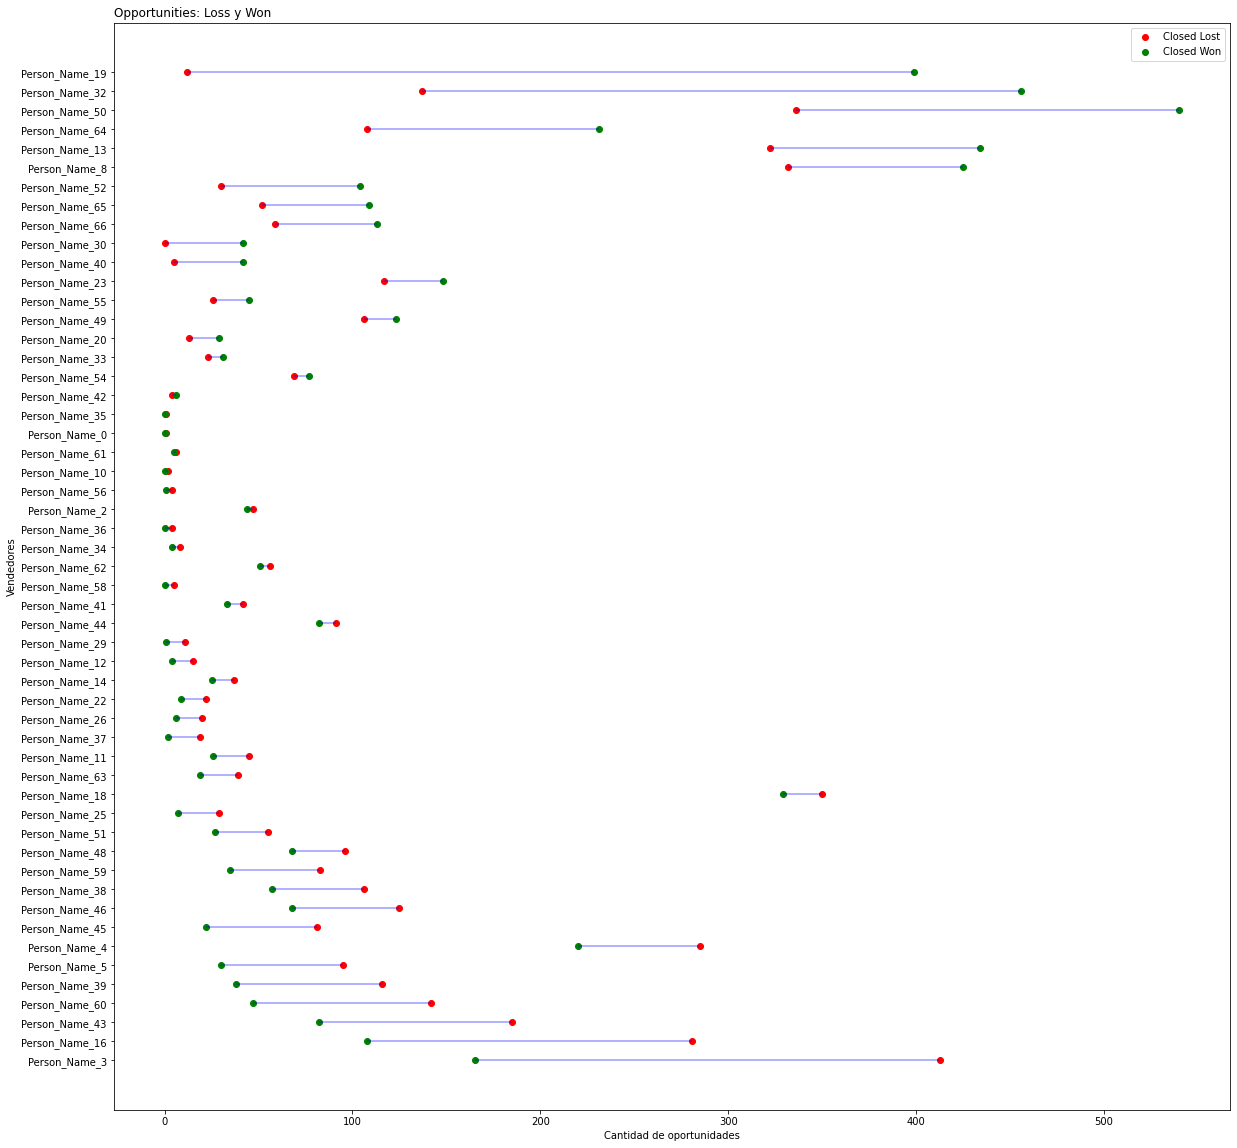

In [ ]:
# Grafico horizontal lollipop para oportunidades:
my_range=range(1,len(group_owners_unstacked.index)+1)
ordered_group = group_owners_unstacked.sort_values('diff',ascending = True)
ordered_group = ordered_group.reset_index()

plt.figure(figsize=(20,20))

plt.hlines(y=my_range, xmin=ordered_group['Closed Lost'], xmax=ordered_group['Closed Won'], color='blue', alpha=0.4)
plt.scatter(ordered_group['Closed Lost'], my_range, color='red', alpha=1, label='Closed Lost')
plt.scatter(ordered_group['Closed Won'], my_range, color='green', alpha=1 , label='Closed Won')
plt.legend()
 
# Add title and axis names
plt.yticks(my_range, ordered_group['Opportunity_Owner'])
plt.title("Opportunities: Loss y Won", loc='left')
plt.xlabel('Cantidad de oportunidades')
plt.ylabel('Vendedores')

plt.savefig('Vendedores_opportunities',dpi=400)


#### Vendedores por Amount

In [ ]:
# Grafico para owners por amount:

group_owners = datos_oportunidades.groupby(['Opportunity_Owner','Stage'])\
                                  .agg({'Territory':'count','Total_Amount(Converted)':'sum'})\
                                  .rename(columns={'Territory':'Opportunities','Total_Amount(Converted)':'Total_Amount'})

# Reacomodamos los datos para el grafico:
group_owners_unstacked = group_owners.Total_Amount.unstack()
group_owners_unstacked = group_owners_unstacked.fillna(0)

# Se calcula la metrica
group_owners_unstacked['Metrica'] = (group_owners_unstacked['Closed Won']-group_owners_unstacked['Closed Lost'])\
                                   /(group_owners_unstacked['Closed Won']+group_owners_unstacked['Closed Lost'])

group_owners_unstacked['diff'] = group_owners_unstacked['Closed Won']-group_owners_unstacked['Closed Lost']
group_owners_unstacked.head(3)

Stage,Closed Lost,Closed Won,Metrica,diff
Opportunity_Owner,,,,
Person_Name_0,6.510611e+05,0.00,-1.00000,-6.510611e+05
Person_Name_10,3.291169e+07,0.00,-1.00000,-3.291169e+07
Person_Name_11,7.202997e+07,1904933.05,-0.94847,-7.012504e+07


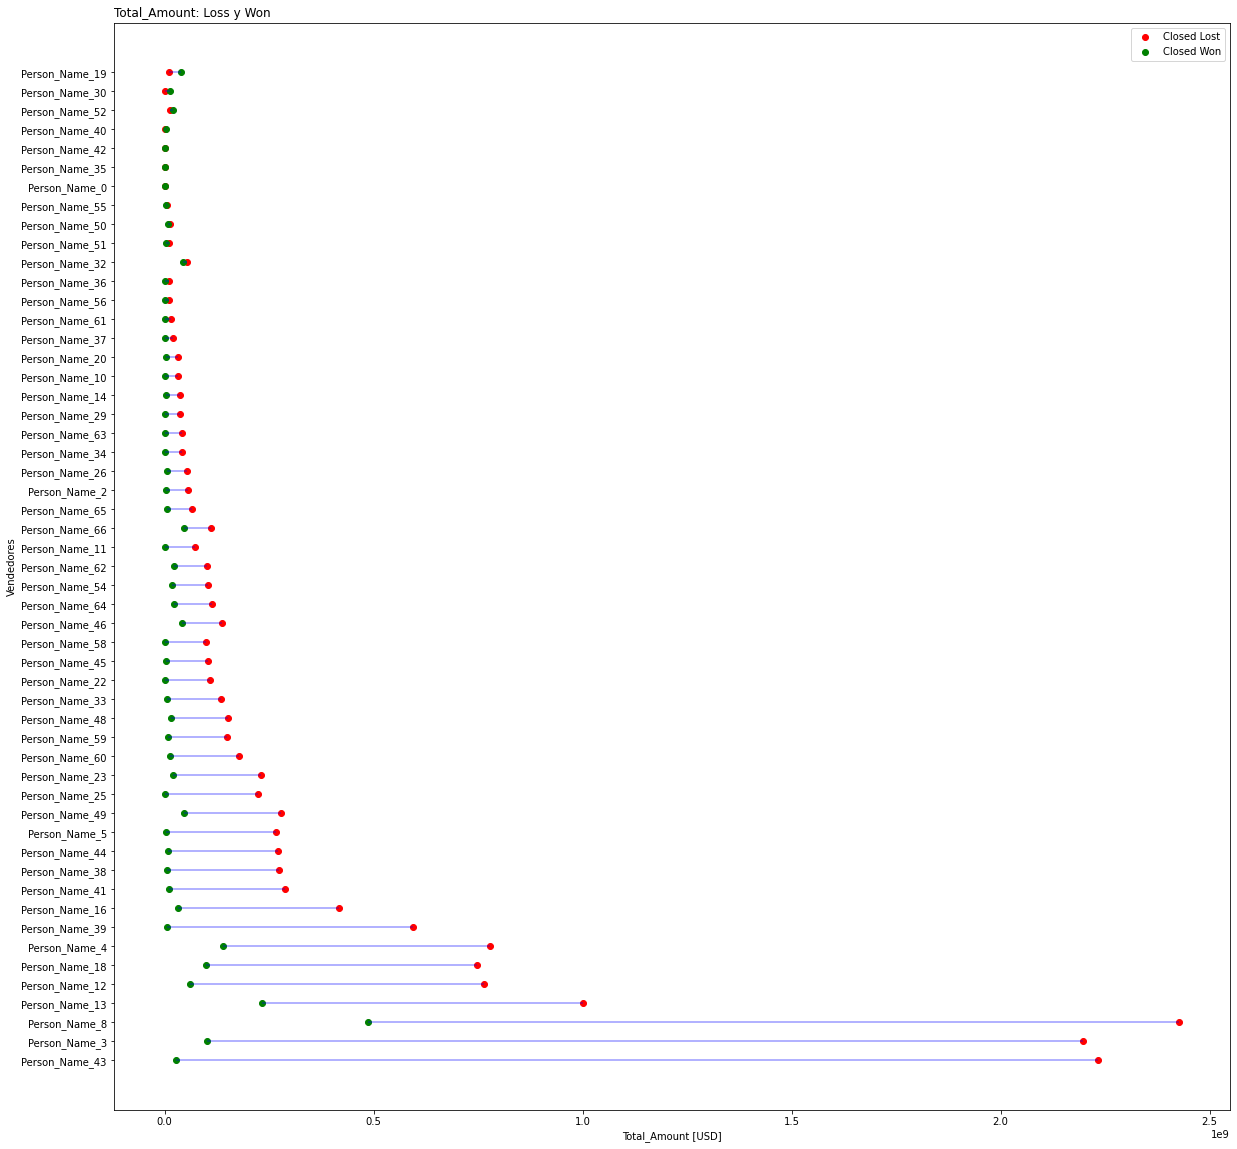

In [ ]:
# Grafico horizontal lollipop por Total_Amount:
my_range=range(1,len(group_owners_unstacked.index)+1)
ordered_group = group_owners_unstacked.sort_values('diff',ascending = True)
ordered_group = ordered_group.reset_index()

plt.figure(figsize=(20,20))

plt.hlines(y=my_range, xmin=ordered_group['Closed Lost'], xmax=ordered_group['Closed Won'], color='blue', alpha=0.4)
plt.scatter(ordered_group['Closed Lost'], my_range, color='red', alpha=1, label='Closed Lost')
plt.scatter(ordered_group['Closed Won'], my_range, color='green', alpha=1 , label='Closed Won')
plt.legend()
 
# Add title and axis names
plt.yticks(my_range, ordered_group['Opportunity_Owner'])
plt.title("Total_Amount: Loss y Won", loc='left')
plt.xlabel('Total_Amount [USD]')
plt.ylabel('Vendedores')

plt.savefig('Vendedores_amounts',dpi=400)


## Analisis de datos para distintas regiones

###Region EMEA

#### Armado dataframe

In [ ]:
# Filtramos los datos de la region
datos_region = datos[datos.Region==region_EMEA]
datos_region = datos_region[~(datos_region['Territory']=='None')] # limpieza de los None

# Datos que se repiten para las entradas de una misma oportunidad:
datos_unicos_oportunidades = datos_region[['Opportunity_Name','Territory','Stage','Source','Account_Name'\
                                           ,'Opportunity_Created_Date','Opportunity_Owner','Opportunity_Year','Semester']]\
                                           .drop_duplicates()
# Agrupamos oportunidades
datos_EMEA_oportunidades = datos_region.groupby('Opportunity_Name')\
                                       .agg({'Total_Amount_Converted':'sum','TRF':'sum','Opportunity_ID':'count'})\
                                       .rename(columns={'Total_Amount_Converted':'Total_Amount(Converted)','TRF':'Total_TRF','Opportunity_ID':'Items'})\
                                       .join(datos_unicos_oportunidades.set_index('Opportunity_Name'))

datos_EMEA_oportunidades.head(3)


,Total_Amount(Converted),Total_TRF,Items,Territory,Stage,Source,Account_Name,Opportunity_Created_Date,Opportunity_Owner,Opportunity_Year,Semester
Opportunity_Name,,,,,,,,,,,
Opportunity_Name_100,615060.495,2,1,Germany,Closed Won,Source_7,Account_Name_1275,2017-04-12,Person_Name_41,2017,1
Opportunity_Name_10022,79605.900,0,1,Germany,Closed Won,Source_9,Account_Name_697,2016-07-20,Person_Name_13,2016,1
Opportunity_Name_10024,27216.875,0,1,Germany,Closed Lost,None,Account_Name_696,2017-01-19,Person_Name_13,2017,1


####Analisis 1: montos ganados y perdidos por territorio

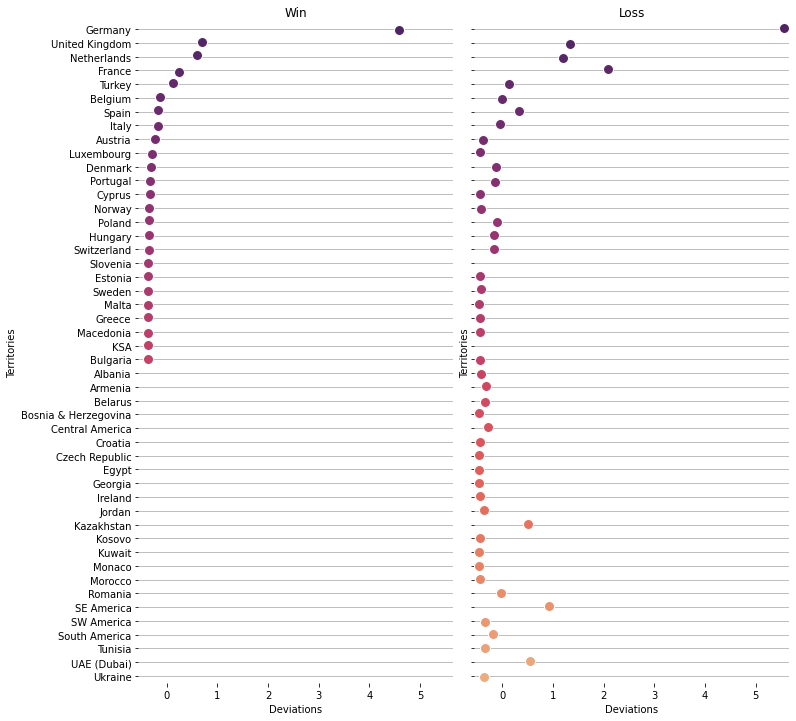

In [ ]:
# Grafico:

group1_EMEA = datos_EMEA_oportunidades.groupby(['Territory','Stage'])\
                                      .agg({'Territory':'count','Total_Amount(Converted)':'sum'})\
                                      .rename(columns={'Territory':'Opportunities','Total_Amount(Converted)':'Total_Amount'})

# Reacomodamos los datos para el grafico:
group1_unstacked_EMEA = group1_EMEA.Total_Amount.unstack()

# Se calcula la metrica
group1_unstacked_EMEA['Metrica'] = (group1_unstacked_EMEA['Closed Won']-group1_unstacked_EMEA['Closed Lost'])\
                                  /(group1_unstacked_EMEA['Closed Won']+group1_unstacked_EMEA['Closed Lost'])


# NORMALIZACION:

# A cada Total_Amount le restamos la media(muestral) y dividimos por el desvio muestral:
mean_won = group1_unstacked_EMEA['Closed Won'].mean()
std_won = group1_unstacked_EMEA['Closed Won'].std()
group1_unstacked_EMEA['Closed Won'] = (group1_unstacked_EMEA['Closed Won']-mean_won)/std_won 

mean_lost = group1_unstacked_EMEA['Closed Lost'].mean()
std_lost = group1_unstacked_EMEA['Closed Lost'].std()
group1_unstacked_EMEA['Closed Lost'] = (group1_unstacked_EMEA['Closed Lost']-mean_lost)/std_lost

# Si quiero achicar distancias tomo logaritmo:
#group1_unstacked_EMEA['Closed Won'] = np.log(group1_unstacked_EMEA['Closed Won'] ) 
#group1_unstacked_EMEA['Closed Lost'] = np.log(group1_unstacked_EMEA['Closed Lost'] )

territories = group1_unstacked_EMEA.reset_index()
ter_and_opo = territories[["Territory","Closed Won","Closed Lost"]]


# GRAFICO:
g = sns.PairGrid(ter_and_opo.sort_values("Closed Won", ascending=False),
                 x_vars=ter_and_opo.columns[1:], y_vars=["Territory"],
                 height=10, aspect=0.5)

# Hacemos el plot
g_map = g.map(sns.stripplot, size=10, orient="h",
              palette="flare_r", linewidth=1, edgecolor="w")


# Limites en x segun el valor maximo y minimo, +/- delta para no recortar:
delta = 0.1
xmin = min(group1_unstacked_EMEA['Closed Lost'].min(),group1_unstacked_EMEA['Closed Won'].min())-delta
xmax = max(group1_unstacked_EMEA['Closed Lost'].max(),group1_unstacked_EMEA['Closed Won'].max())+delta

g.set(xlim=(xmin, xmax),xlabel="Deviations", ylabel="Territories")

# Titulos para las columnas del grafico
titles = ["Win", "Loss"]

for ax, title in zip(g.axes.flat, titles):
    ax.set(title=title)
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

#g_map.savefig('')


#### Analisis 2
Mejores clientes de la region

In [ ]:
# Para la region, agrupamos oportunidades por clientes:
group2_EMEA = datos_EMEA_oportunidades.groupby(['Account_Name','Stage'])\
                                      .agg({'Items':'count','Total_Amount(Converted)':'sum'})\
                                      .rename(columns={'Items':'Opportunities','Total_Amount(Converted)':'Total_Amount'})
group2_EMEA.head(3)

,,Opportunities,Total_Amount
Account_Name,Stage,,
Account_Name_10,Closed Lost,1,114693.15
Account_Name_1000,Closed Lost,1,116898.60
Account_Name_1011,Closed Lost,1,2455618.10


In [ ]:
group2_EMEA = group2_EMEA.reset_index()

# En una columna le agregamos signo a total amount: (+) si es Won, (-) si es Lost:
group2_EMEA['Total_Amount_signed']= ((group2_EMEA['Stage']=='Closed Won')*2-1)*group2_EMEA['Total_Amount']


# Sumo el total, el neto, y total de oportunidadeS:
group2_aux_EMEA = group2_EMEA.groupby('Account_Name')\
                             .agg({'Total_Amount_signed':'sum','Total_Amount':'sum','Opportunities':'sum'})\
                             .rename(columns={'Total_Amount_signed':'Neto','Total_Amount':'Total','Opportunities':'Oportunidades'})

group2_aux_EMEA['Metrica'] = group2_aux_EMEA['Neto']/group2_aux_EMEA['Total']
group2_aux_EMEA = group2_aux_EMEA.sort_values(['Metrica','Neto'],ascending = False)

group2_aux_EMEA#.nlargest(15,'Oportunidades')#.reset_index().Account_Name.value_counts().sum() >> 490 clientes

,Neto,Total,Oportunidades,Metrica
Account_Name,,,,
Account_Name_269,6.647692e+06,6.647692e+06,1,1.0
Account_Name_405,5.459403e+06,5.459403e+06,1,1.0
Account_Name_1718,5.247766e+06,5.247766e+06,1,1.0
Account_Name_191,4.595660e+06,4.595660e+06,5,1.0
Account_Name_1719,4.008975e+06,4.008975e+06,1,1.0
...,...,...,...,...
Account_Name_583,-1.237578e+08,1.237578e+08,2,-1.0
Account_Name_404,-1.762234e+08,1.762234e+08,6,-1.0
Account_Name_285,-2.140388e+08,2.140388e+08,2,-1.0


/usr/local/lib/python3.6/dist-packages/seaborn/relational.py:627: RuntimeWarning: invalid value encountered in sqrt
  kws.setdefault("linewidth", .08 * np.sqrt(np.percentile(s, 10)))
/usr/local/lib/python3.6/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


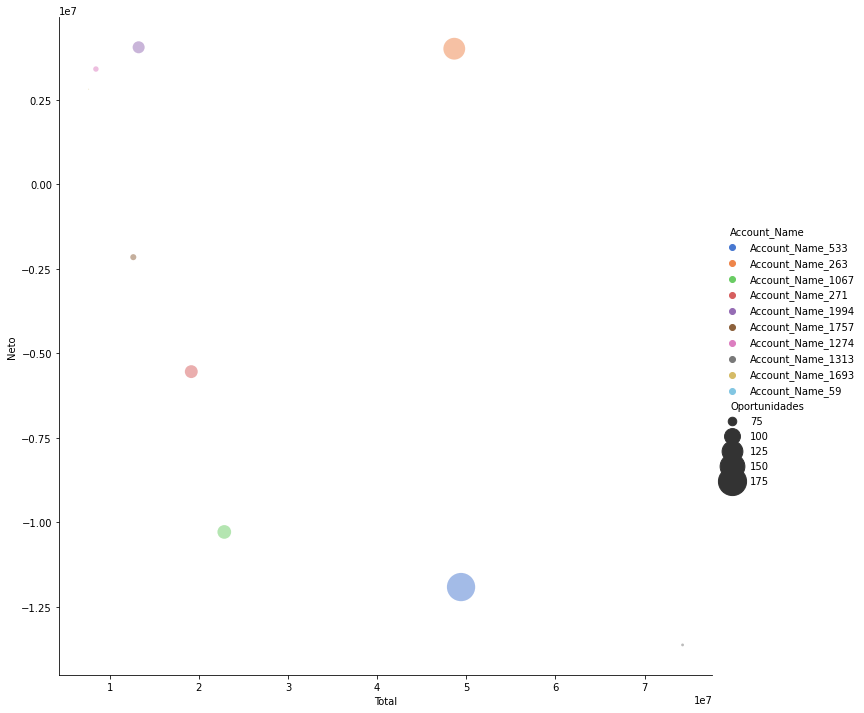

In [ ]:
groupping2_EMEA = group2_aux_EMEA.nlargest(10,"Oportunidades")
plot2_EMEA = sns.relplot(x="Total", y="Neto", hue="Account_Name", size="Oportunidades",
                         sizes=(-100,800),alpha=.5, palette="muted",height=10, data=groupping2_EMEA,)

#plot2_EMEA.savefig('Analisis2_EMEA',dpi=400)

#### Analisis 3
Este analisis no se incluye en el informe

In [ ]:
group3 = datos_EMEA_oportunidades.groupby(['Account_Name','Stage'])\
                                 .agg({'Items':'count','Total_Amount(Converted)':'sum'})\
                                 .rename(columns={'Items':'Opportunities','Total_Amount(Converted)':'Total_Amount'})

# Se calcula el promedio de monto por oportunidad para cada vendedor:
group3['Mean_Amount'] = group3['Total_Amount']/group3['Opportunities']

group3.head(3)

,,Opportunities,Total_Amount,Mean_Amount
Account_Name,Stage,,,
Account_Name_10,Closed Lost,1,114693.15,114693.15
Account_Name_1000,Closed Lost,1,116898.60,116898.60
Account_Name_1011,Closed Lost,1,2455618.10,2455618.10


In [ ]:
group3 = group3.reset_index()

# En una columna le agregamos signo a total amount: (+) si es Won, (-) si es Lost:
group3['Total_Amount_signed']= ((group3['Stage']=='Closed Won')*2-1)*group3['Total_Amount']

group_aux = group3.groupby('Account_Name')\
                  .agg({'Total_Amount_signed':'sum','Total_Amount':'sum'})\
                  .rename(columns={'Total_Amount_signed':'Numerador','Total_Amount':'Denominador'})

group_aux['Metric_A'] = group_aux.Numerador/group_aux.Denominador
group_aux = group_aux.sort_values(['Metric_A','Numerador'],ascending = False)

group_aux.head(5)

,Numerador,Denominador,Metric_A
Account_Name,,,
Account_Name_269,6.647692e+06,6.647692e+06,1.0
Account_Name_405,5.459403e+06,5.459403e+06,1.0
Account_Name_1718,5.247766e+06,5.247766e+06,1.0
Account_Name_191,4.595660e+06,4.595660e+06,1.0
Account_Name_1719,4.008975e+06,4.008975e+06,1.0


In [ ]:
group3 = group3.set_index('Account_Name')
ordered_group3 = group3.loc[group_aux.index] # abuso de notacion??
ordered_group3.head(10)

,Stage,Opportunities,Total_Amount,Mean_Amount,Total_Amount_signed
Account_Name,,,,,
Account_Name_269,Closed Won,1,6.647692e+06,6.647692e+06,6.647692e+06
Account_Name_405,Closed Won,1,5.459403e+06,5.459403e+06,5.459403e+06
Account_Name_1718,Closed Won,1,5.247766e+06,5.247766e+06,5.247766e+06
Account_Name_191,Closed Won,5,4.595660e+06,9.191321e+05,4.595660e+06
Account_Name_1719,Closed Won,1,4.008975e+06,4.008975e+06,4.008975e+06
Account_Name_2043,Closed Won,1,1.647071e+06,1.647071e+06,1.647071e+06
Account_Name_337,Closed Won,1,1.587612e+06,1.587612e+06,1.587612e+06
Account_Name_2047,Closed Won,4,1.091677e+06,2.729192e+05,1.091677e+06
Account_Name_33,Closed Won,2,9.745609e+05,4.872804e+05,9.745609e+05


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning

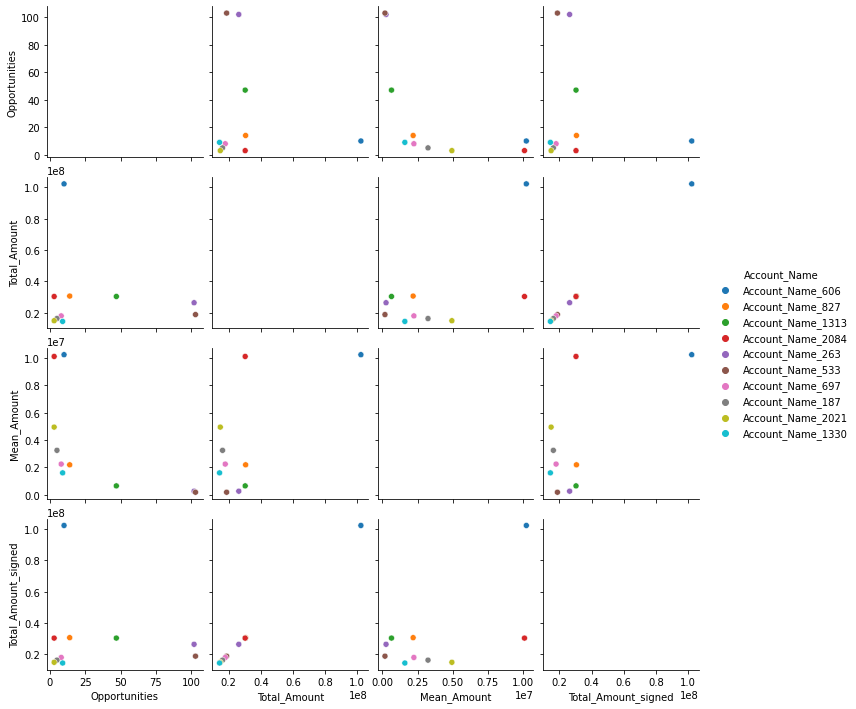

In [ ]:
groupping3 = group3.reset_index()[["Account_Name","Opportunities","Total_Amount","Mean_Amount","Total_Amount_signed"]]
groupping3 = groupping3.nlargest(10,"Total_Amount_signed")
sns.pairplot(groupping3, hue="Account_Name")

###Region Americas

####Armado dataframe

In [ ]:
# Filtramos los datos de la region:
datos_region = datos[datos.Region==region_Americas]
datos_region = datos_region[~(datos_region['Territory']=='None')]

# Datos que se repiten para las entradas de una misma oportunidad:
datos_unicos_oportunidades = datos_region[['Opportunity_Name','Territory','Stage','Source','Account_Name'\
                                           ,'Opportunity_Created_Date','Opportunity_Owner','Opportunity_Year','Semester']]\
                                           .drop_duplicates()
# Agrupamos oportunidades:
datos_Americas_oportunidades = datos_region.groupby('Opportunity_Name')\
                                           .agg({'Total_Amount_Converted':'sum','TRF':'sum','Opportunity_ID':'count'})\
                                           .rename(columns={'Total_Amount_Converted':'Total_Amount(Converted)','TRF':'Total_TRF','Opportunity_ID':'Items'})\
                                           .join(datos_unicos_oportunidades.set_index('Opportunity_Name'))

datos_Americas_oportunidades.head(3)

,Total_Amount(Converted),Total_TRF,Items,Territory,Stage,Source,Account_Name,Opportunity_Created_Date,Opportunity_Owner,Opportunity_Year,Semester
Opportunity_Name,,,,,,,,,,,
Opportunity_Name_0,3494400.0,7,7,NW America,Closed Lost,Source_7,Account_Name_265,2016-03-04,Person_Name_8,2016,1
Opportunity_Name_1,2193100.0,4,7,NW America,Closed Lost,Source_7,Account_Name_548,2016-03-05,Person_Name_33,2016,1
Opportunity_Name_10023,2870.0,0,1,SE America,Closed Won,None,Account_Name_1407,2017-01-03,Person_Name_38,2017,1


####Analisis 1:

Montos ganados y perdidos por territorio

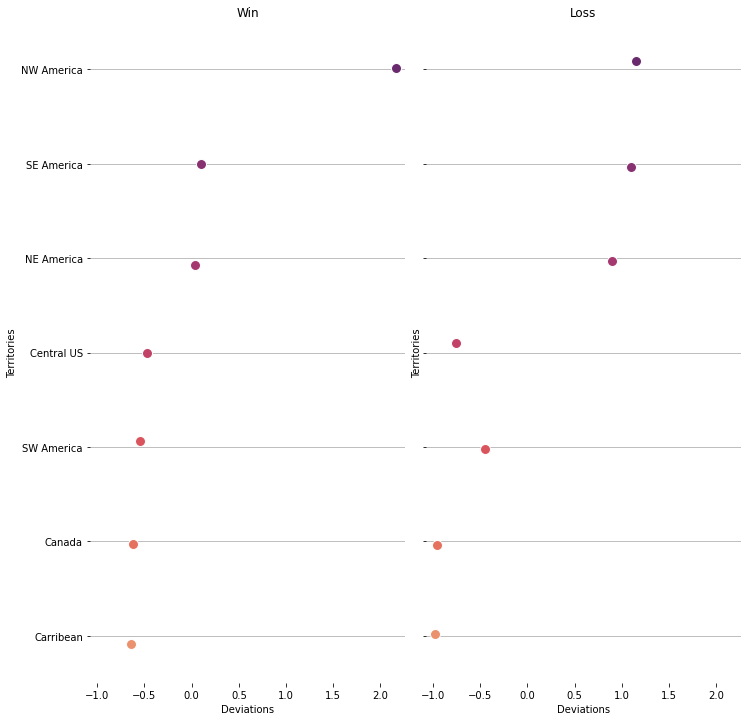

In [ ]:
# Agrupamos territorios y stages:

group1_Americas = datos_Americas_oportunidades.groupby(['Territory','Stage'])\
                                              .agg({'Territory':'count','Total_Amount(Converted)':'sum'})\
                                              .rename(columns={'Territory':'Opportunities','Total_Amount(Converted)':'Total_Amount'})

# Reacomodamos los datos para el grafico:
group1_unstacked_Americas = group1_Americas.Total_Amount.unstack()

# Se calcula la metrica
group1_unstacked_Americas['Metrica'] = (group1_unstacked_Americas['Closed Won']-group1_unstacked_Americas['Closed Lost'])\
                                      /(group1_unstacked_Americas['Closed Won']+group1_unstacked_Americas['Closed Lost'])


# NORMALIZACION:

# A cada Total_Amount le restamos la media(muestral) y dividimos por el desvio muestral:
mean_won = group1_unstacked_Americas['Closed Won'].mean()
std_won = group1_unstacked_Americas['Closed Won'].std()
group1_unstacked_Americas['Closed Won'] = (group1_unstacked_Americas['Closed Won']-mean_won)/std_won 

mean_lost = group1_unstacked_Americas['Closed Lost'].mean()
std_lost = group1_unstacked_Americas['Closed Lost'].std()
group1_unstacked_Americas['Closed Lost'] = (group1_unstacked_Americas['Closed Lost']-mean_lost)/std_lost

# Logaritmo para achicar escalas:
#group1_unstacked_Americas['Closed Won'] = np.log(group1_unstacked_Americas['Closed Won'] ) 
#group1_unstacked_Americas['Closed Lost'] = np.log(group1_unstacked_Americas['Closed Lost'] )

territories = group1_unstacked_Americas.reset_index()
ter_and_opo = territories[["Territory","Closed Won","Closed Lost"]]


# GRAFICO:
g = sns.PairGrid(ter_and_opo.sort_values("Closed Won", ascending=False),
                 x_vars=ter_and_opo.columns[1:], y_vars=["Territory"],
                 height=10, aspect=0.5)

# Hacemos el plot
g.map(sns.stripplot, size=10, orient="h",
      palette="flare_r", linewidth=1, edgecolor="w")


# Limites en x segun el valor maximo y minimo, +/- delta para no recortar:
delta = 0.1
xmin = min(group1_unstacked_Americas['Closed Lost'].min(),group1_unstacked_Americas['Closed Won'].min())-delta
xmax = max(group1_unstacked_Americas['Closed Lost'].max(),group1_unstacked_Americas['Closed Won'].max())+delta

g.set(xlim=(xmin, xmax),xlabel="Deviations", ylabel="Territories")

# Titulos para las columnas del grafico
titles = ["Win", "Loss", "Mean Amount"]

for ax, title in zip(g.axes.flat, titles):
    ax.set(title=title)
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

#### Analisis 2
Mejores clientes de la region

In [ ]:
# Para la region, agrupamos oportunidades por clientes:
group2_Americas = datos_Americas_oportunidades.groupby(['Account_Name','Stage'])\
                                              .agg({'Items':'count','Total_Amount(Converted)':'sum'})\
                                              .rename(columns={'Items':'Opportunities','Total_Amount(Converted)':'Total_Amount'})
group2_Americas.head(3)

Opportunities  Total_Amount
Account_Name      Stage                                   
Account_Name_1006 Closed Lost              5  1.744651e+08
                  Closed Won               1  8.136744e+05
Account_Name_1018 Closed Lost              1  1.120125e+05

In [ ]:
group2_Americas = group2_Americas.reset_index()

# En una columna le agregamos signo a total amount: (+) si es Won, (-) si es Lost:
group2_Americas['Total_Amount_signed']= ((group2_Americas['Stage']=='Closed Won')*2-1)*group2_Americas['Total_Amount']

group2_Americas.drop(columns='Stage')

# Sumo el total, el neto, y total de oportunidadeS:
group2_aux_Americas = group2_Americas.groupby('Account_Name')\
                                     .agg({'Total_Amount_signed':'sum','Total_Amount':'sum','Opportunities':'sum'})\
                                     .rename(columns={'Total_Amount_signed':'Neto','Total_Amount':'Total','Opportunities':'Oportunidades'})

group2_aux_Americas['Metrica'] = group2_aux_Americas['Neto']/group2_aux_Americas['Total']
group2_aux_Americas = group2_aux_Americas.sort_values(['Metrica','Neto'],ascending = False)

group2_aux_Americas#.nlargest(15,'Oportunidades')#.reset_index().Account_Name.value_counts().sum()

,Neto,Total,Oportunidades,Metrica
Account_Name,,,,
Account_Name_1905,2.869389e+06,2.869389e+06,1,1.0
Account_Name_1824,2.855358e+06,2.855358e+06,1,1.0
Account_Name_722,8.632260e+05,8.632260e+05,1,1.0
Account_Name_1808,6.673900e+05,6.673900e+05,15,1.0
Account_Name_1390,6.648075e+05,6.648075e+05,1,1.0
...,...,...,...,...
Account_Name_623,-3.150001e+08,3.150001e+08,1,-1.0
Account_Name_1582,-4.637920e+08,4.637920e+08,12,-1.0
Account_Name_130,0.000000e+00,0.000000e+00,1,NaN


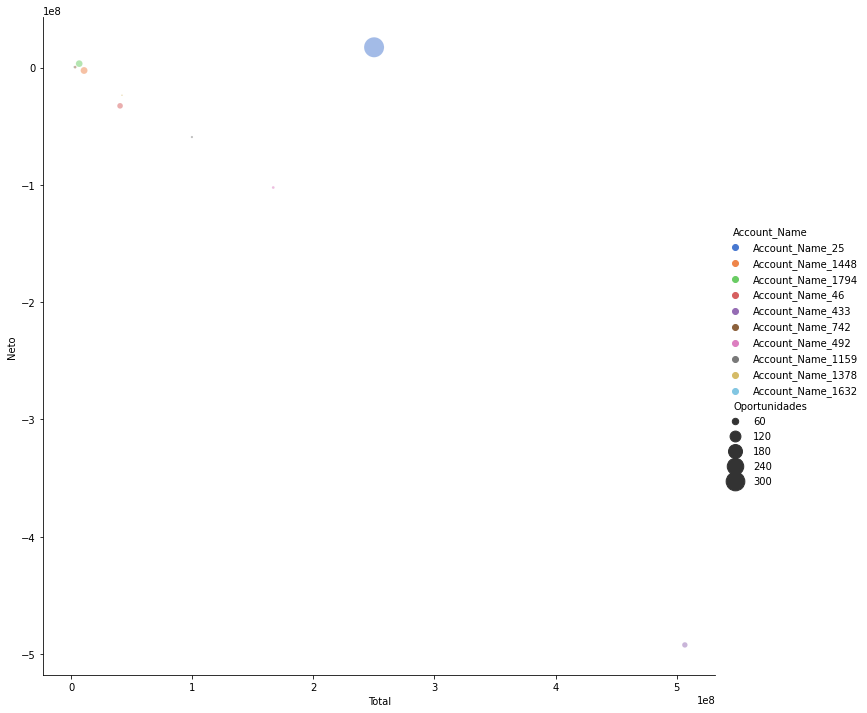

In [ ]:
groupping2_Americas = group2_aux_Americas.nlargest(10,"Oportunidades")

plot2_Americas = sns.relplot(x="Total", y="Neto", hue="Account_Name", size="Oportunidades",
                             sizes=(1, 400), alpha=.5, palette="muted",
                             height=10, data=groupping2_Americas)

#plot2_Americas.savefig('Analisis2_Americas',dpi=400)

###Region APAC

#### Armado del dataframe

In [ ]:
# Filtramos los datos de la region
datos_region = datos[datos.Region==region_APAC]
datos_region = datos_region[~(datos_region['Territory']=='None')] # limpieza de los None

# Datos que se repiten para las entradas de una misma oportunidad:
datos_unicos_oportunidades = datos_region[['Opportunity_Name','Territory','Stage','Source','Account_Name'\
                                           ,'Opportunity_Created_Date','Opportunity_Owner','Opportunity_Year','Semester']]\
                                           .drop_duplicates()
# Agrupamos oportunidades
datos_APAC_oportunidades = datos_region.groupby('Opportunity_Name')\
                                       .agg({'Total_Amount_Converted':'sum','TRF':'sum','Opportunity_ID':'count'})\
                                       .rename(columns={'Total_Amount_Converted':'Total_Amount(Converted)','TRF':'Total_TRF','Opportunity_ID':'Items'})\
                                       .join(datos_unicos_oportunidades.set_index('Opportunity_Name'))

datos_APAC_oportunidades.head(3)

,Total_Amount(Converted),Total_TRF,Items,Territory,Stage,Source,Account_Name,Opportunity_Created_Date,Opportunity_Owner,Opportunity_Year,Semester
Opportunity_Name,,,,,,,,,,,
Opportunity_Name_10000,19600.0,0,1,Indonesia,Closed Lost,None,Account_Name_339,2016-12-09,Person_Name_11,2016,2
Opportunity_Name_10001,43352.7,0,1,Indonesia,Closed Won,None,Account_Name_339,2016-11-01,Person_Name_11,2016,2
Opportunity_Name_10002,92463.0,0,1,India,Closed Lost,None,Account_Name_1420,2017-05-12,Person_Name_60,2017,1


####Analisis 1: 
Montos ganados y perdidos por territorio

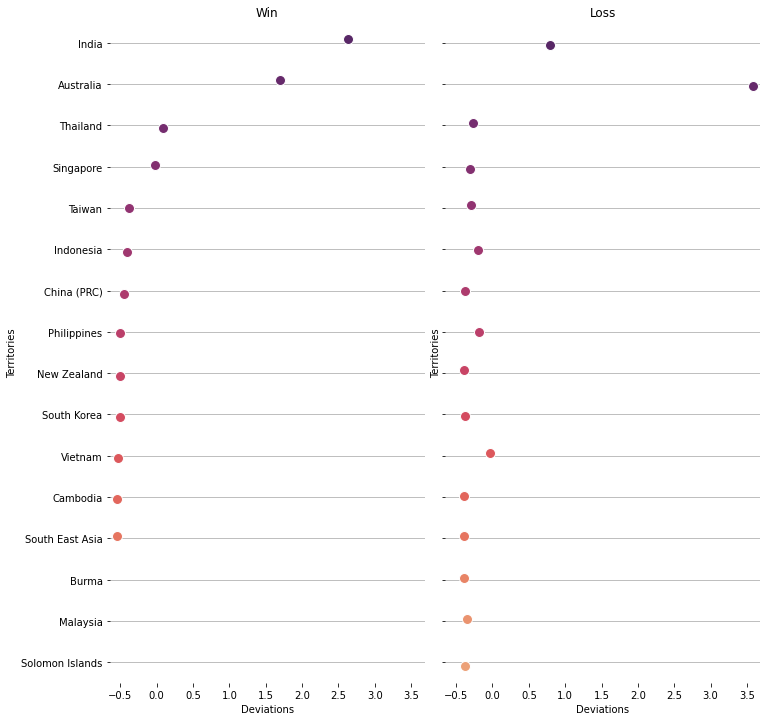

In [ ]:
# Agrupamos territorios y stages:

group1_APAC = datos_APAC_oportunidades.groupby(['Territory','Stage'])\
                                      .agg({'Territory':'count','Total_Amount(Converted)':'sum'})\
                                      .rename(columns={'Territory':'Opportunities','Total_Amount(Converted)':'Total_Amount'})

# Reacomodamos los datos para el grafico:
group1_unstacked_APAC = group1_APAC.Total_Amount.unstack()

# Se calcula la metrica
group1_unstacked_APAC['Metrica'] = (group1_unstacked_APAC['Closed Won']-group1_unstacked_APAC['Closed Lost'])\
                                  /(group1_unstacked_APAC['Closed Won']+group1_unstacked_APAC['Closed Lost'])


# NORMALIZACION:

# A cada Total_Amount le restamos la media(muestral) y dividimos por el desvio muestral:
mean_won = group1_unstacked_APAC['Closed Won'].mean()
std_won  = group1_unstacked_APAC['Closed Won'].std()
group1_unstacked_APAC['Closed Won'] = (group1_unstacked_APAC['Closed Won']-mean_won)/std_won 

mean_lost = group1_unstacked_APAC['Closed Lost'].mean()
std_lost  = group1_unstacked_APAC['Closed Lost'].std()
group1_unstacked_APAC['Closed Lost'] = (group1_unstacked_APAC['Closed Lost']-mean_lost)/std_lost

# Logaritmo para achicar escalas:
#group1_unstacked_APAC['Closed Won'] = np.log(group1_unstacked_APAC['Closed Won'] ) 
#group1_unstacked_APAC['Closed Lost'] = np.log(group1_unstacked_APAC['Closed Lost'] )

territories = group1_unstacked_APAC.reset_index()
ter_and_opo = territories[["Territory","Closed Won","Closed Lost"]]


# GRAFICO:
g = sns.PairGrid(ter_and_opo.sort_values("Closed Won", ascending=False),
                 x_vars=ter_and_opo.columns[1:], y_vars=["Territory"],
                 height=10, aspect=0.5)

# Hacemos el plot
g.map(sns.stripplot, size=10, orient="h",
      palette="flare_r", linewidth=1, edgecolor="w")


# Limites en x segun el valor maximo y minimo, +/- delta para no recortar:
delta = 0.1
xmin = min(group1_unstacked_APAC['Closed Lost'].min(),group1_unstacked_APAC['Closed Won'].min())-delta
xmax = max(group1_unstacked_APAC['Closed Lost'].max(),group1_unstacked_APAC['Closed Won'].max())+delta

g.set(xlim=(xmin, xmax),xlabel="Deviations", ylabel="Territories")

# Titulos para las columnas del grafico
titles = ["Win", "Loss", "Mean Amount"]

for ax, title in zip(g.axes.flat, titles):
    ax.set(title=title)
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)


sns.despine(left=True, bottom=True)

#### Analisis 2
Mejores clientes de la region

In [ ]:
# Para la region, agrupamos oportunidades por clientes:
group2_APAC = datos_APAC_oportunidades.groupby(['Account_Name','Stage'])\
                                      .agg({'Items':'count','Total_Amount(Converted)':'sum'})\
                                      .rename(columns={'Items':'Opportunities','Total_Amount(Converted)':'Total_Amount'})
group2_APAC.head()

,,Opportunities,Total_Amount
Account_Name,Stage,,
Account_Name_0,Closed Won,1,26520.0
Account_Name_1001,Closed Won,1,11262.5
Account_Name_1002,Closed Won,1,916742.4
Account_Name_1004,Closed Lost,1,144768.0
Account_Name_1007,Closed Lost,1,4954950.0


In [ ]:
group2_APAC = group2_APAC.reset_index()

# En una columna le agregamos signo a total amount: (+) si es Won, (-) si es Lost:
group2_APAC['Total_Amount_signed']= ((group2_APAC['Stage']=='Closed Won')*2-1)*group2_APAC['Total_Amount']

group2_APAC.drop(columns='Stage')

# Sumo el total, el neto, y total de oportunidadeS:
group2_aux_APAC = group2_APAC.groupby('Account_Name')\
                            .agg({'Total_Amount_signed':'sum','Total_Amount':'sum','Opportunities':'sum'})\
                            .rename(columns={'Total_Amount_signed':'Neto','Total_Amount':'Total','Opportunities':'Oportunidades'})

group2_aux_APAC['Metrica'] = group2_aux_APAC['Neto']/group2_aux_APAC['Total']
group2_aux_APAC = group2_aux_APAC.sort_values(['Metrica','Neto'],ascending = False)

group2_aux_APAC#.nlargest(15,'Oportunidades')#.reset_index().Account_Name.value_counts().sum() 

,Neto,Total,Oportunidades,Metrica
Account_Name,,,,
Account_Name_1528,3.193310e+06,3.193310e+06,2,1.0
Account_Name_1540,2.443170e+06,2.443170e+06,1,1.0
Account_Name_231,1.999082e+06,1.999082e+06,19,1.0
Account_Name_1340,1.888053e+06,1.888053e+06,1,1.0
Account_Name_246,1.487644e+06,1.487644e+06,1,1.0
...,...,...,...,...
Account_Name_554,-2.613073e+08,2.613073e+08,6,-1.0
Account_Name_1376,-6.543397e+08,6.543397e+08,15,-1.0
Account_Name_1293,0.000000e+00,0.000000e+00,1,NaN


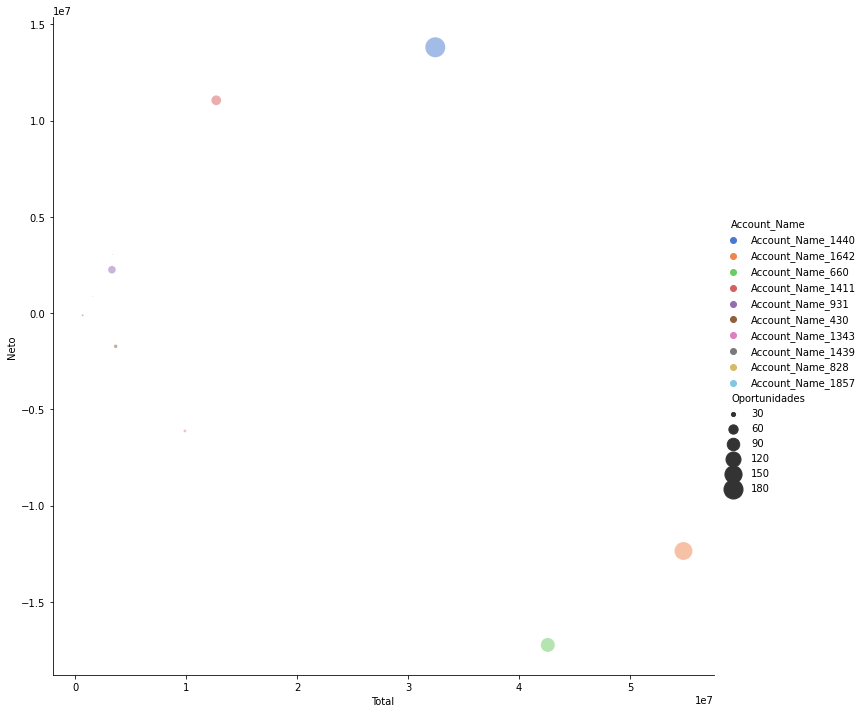

In [ ]:
groupping2_APAC = group2_aux_APAC.nlargest(10,"Oportunidades")

plot2_APAC = sns.relplot(x="Total", y="Neto", hue="Account_Name", size="Oportunidades",
                         sizes=(1, 400), alpha=.5, palette="muted",
                         height=10, data=groupping2_APAC)

#plot2_APAC.savefig('Analisis2_APAC',dpi=400)

###Region Middle east

#### Armado del dataframe

In [ ]:
# Filtramos los datos de la region
datos_region = datos[datos.Region==region_ME]
datos_region = datos_region[~(datos_region['Territory']=='None')] # limpieza de los None

# Datos que se repiten para las entradas de una misma oportunidad:
datos_unicos_oportunidades = datos_region[['Opportunity_Name','Territory','Stage','Source','Account_Name'\
                                           ,'Opportunity_Created_Date','Opportunity_Owner','Opportunity_Year','Semester']]\
                                           .drop_duplicates()
# Agrupamos oportunidades
datos_ME_oportunidades = datos_region.groupby('Opportunity_Name')\
                                     .agg({'Total_Amount_Converted':'sum','TRF':'sum','Opportunity_ID':'count'})\
                                     .rename(columns={'Total_Amount_Converted':'Total_Amount(Converted)','TRF':'Total_TRF','Opportunity_ID':'Items'})\
                                     .join(datos_unicos_oportunidades.set_index('Opportunity_Name'))

datos_ME_oportunidades.head(3)

,Total_Amount(Converted),Total_TRF,Items,Territory,Stage,Source,Account_Name,Opportunity_Created_Date,Opportunity_Owner,Opportunity_Year,Semester
Opportunity_Name,,,,,,,,,,,
Opportunity_Name_10381,955206.0,3,1,Jordan,Closed Lost,None,Account_Name_1455,2016-11-23,Person_Name_5,2016,2
Opportunity_Name_10408,2159935.2,6,1,Jordan,Closed Lost,None,Account_Name_63,2017-06-07,Person_Name_5,2017,1
Opportunity_Name_1125,443190.0,1,1,Jordan,Closed Lost,None,Account_Name_63,2017-05-24,Person_Name_5,2017,1


####Analisis 1: 
Montos ganados y perdidos por territorio

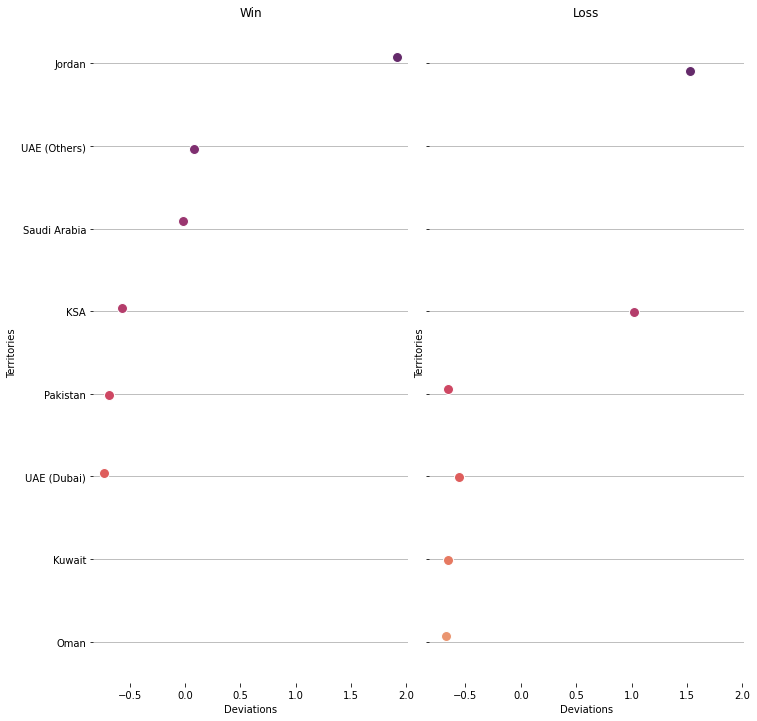

In [ ]:
# Agrupamos territorios y stages:
group1_ME = datos_ME_oportunidades.groupby(['Territory','Stage'])\
                                  .agg({'Territory':'count','Total_Amount(Converted)':'sum'})\
                                  .rename(columns={'Territory':'Opportunities','Total_Amount(Converted)':'Total_Amount'})

# Reacomodamos los datos para el grafico:
group1_unstacked_ME = group1_ME.Total_Amount.unstack()

# Se calcula la metrica
group1_unstacked_ME['Metrica'] = (group1_unstacked_ME['Closed Won']-group1_unstacked_ME['Closed Lost'])\
                                /(group1_unstacked_ME['Closed Won']+group1_unstacked_ME['Closed Lost'])


# NORMALIZACION:

# A cada Total_Amount le restamos la media(muestral) y dividimos por el desvio muestral:
mean_won = group1_unstacked_ME['Closed Won'].mean()
std_won  = group1_unstacked_ME['Closed Won'].std()
group1_unstacked_ME['Closed Won'] = (group1_unstacked_ME['Closed Won']-mean_won)/std_won 

mean_lost = group1_unstacked_ME['Closed Lost'].mean()
std_lost  = group1_unstacked_ME['Closed Lost'].std()
group1_unstacked_ME['Closed Lost'] = (group1_unstacked_ME['Closed Lost']-mean_lost)/std_lost


# Logaritmo para achicar escalas:
#group1_unstacked_ME['Closed Won'] = np.log(group1_unstacked_ME['Closed Won'] ) 
#group1_unstacked_ME['Closed Lost'] = np.log(group1_unstacked_ME['Closed Lost'] )

territories = group1_unstacked_ME.reset_index()
ter_and_opo = territories[["Territory","Closed Won","Closed Lost"]]


# GRAFICO:
g = sns.PairGrid(ter_and_opo.sort_values("Closed Won", ascending=False),
                 x_vars=ter_and_opo.columns[1:], y_vars=["Territory"],
                 height=10, aspect=0.5)

# Hacemos el plot
g.map(sns.stripplot, size=10, orient="h",
      palette="flare_r", linewidth=1, edgecolor="w")


# Limites en x segun el valor maximo y minimo, +/- delta para no recortar:
delta = 0.1
xmin = min(group1_unstacked_ME['Closed Lost'].min(),group1_unstacked_ME['Closed Won'].min())-delta
xmax = max(group1_unstacked_ME['Closed Lost'].max(),group1_unstacked_ME['Closed Won'].max())+delta

g.set(xlim=(xmin, xmax),xlabel="Deviations", ylabel="Territories")

# Titulos para las columnas del grafico
titles = ["Win", "Loss", "Mean Amount"]

for ax, title in zip(g.axes.flat, titles):
    ax.set(title=title)
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

#### Analisis 2
Mejores clientes de la region

In [ ]:
# Para la region, agrupamos oportunidades por clientes:
group2_ME = datos_ME_oportunidades.groupby(['Account_Name','Stage'])\
                                      .agg({'Items':'count','Total_Amount(Converted)':'sum'})\
                                      .rename(columns={'Items':'Opportunities','Total_Amount(Converted)':'Total_Amount'})
group2_ME.head(3)

,,Opportunities,Total_Amount
Account_Name,Stage,,
Account_Name_100,Closed Won,1,78490.5
Account_Name_1028,Closed Lost,1,246960.0
Account_Name_1031,Closed Lost,1,120016.0


In [ ]:
group2_ME = group2_ME.reset_index()

# En una columna le agregamos signo a total amount: (+) si es Won, (-) si es Lost:
group2_ME['Total_Amount_signed']= ((group2_ME['Stage']=='Closed Won')*2-1)*group2_ME['Total_Amount']

group2_ME.drop(columns='Stage')

# Sumo el total, el neto, y total de oportunidadeS:
group2_aux_ME = group2_ME.groupby('Account_Name')\
                            .agg({'Total_Amount_signed':'sum','Total_Amount':'sum','Opportunities':'sum'})\
                            .rename(columns={'Total_Amount_signed':'Neto','Total_Amount':'Total','Opportunities':'Oportunidades'})

group2_aux_ME['Metrica'] = group2_aux_ME['Neto']/group2_aux_ME['Total']
group2_aux_ME = group2_aux_ME.sort_values(['Metrica','Neto'],ascending = False)

group2_aux_ME#.nlargest(15,'Oportunidades')#.reset_index().Account_Name.value_counts().sum()

,Neto,Total,Oportunidades,Metrica
Account_Name,,,,
Account_Name_1047,1350963.20,1350963.20,2,1.000000
Account_Name_99,179239.50,179239.50,2,1.000000
Account_Name_100,78490.50,78490.50,1,1.000000
Account_Name_117,30240.00,30240.00,1,1.000000
Account_Name_751,-158725.50,445834.50,5,-0.356019
Account_Name_306,-610195.20,1510084.20,11,-0.404080
Account_Name_572,-317167.20,738427.20,3,-0.429517
Account_Name_507,-224480.25,401403.15,3,-0.559239
Account_Name_1180,-607074.00,910314.00,4,-0.666884


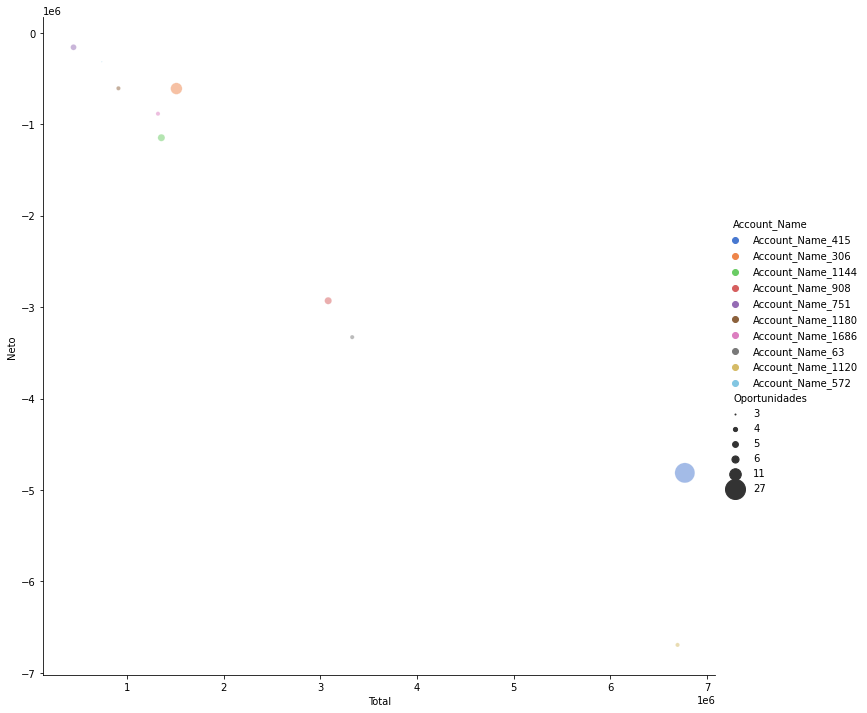

In [ ]:
groupping2_ME = group2_aux_ME.nlargest(10,"Oportunidades")

plot2_ME = sns.relplot(x="Total", y="Neto", hue="Account_Name", size="Oportunidades",
                       sizes=(1, 400), alpha=.5, palette="muted",
                       height=10, data=groupping2_ME)

#plot2_ME.savefig('Analisis2_ME',dpi=400)

###Region JAPAN

#### Armado del dataframe

In [ ]:
# Filtramos los datos de la region
datos_region = datos[datos.Region==region_Japan]
datos_region = datos_region[~(datos_region['Territory']=='None')] # limpieza de los None

# Datos que se repiten para las entradas de una misma oportunidad:
datos_unicos_oportunidades = datos_region[['Opportunity_Name','Territory','Stage','Source','Account_Name'\
                                           ,'Opportunity_Created_Date','Opportunity_Owner','Opportunity_Year','Semester']]\
                                           .drop_duplicates()
# Agrupamos oportunidades
datos_Japan_oportunidades = datos_region.groupby('Opportunity_Name')\
                                        .agg({'Total_Amount_Converted':'sum','TRF':'sum','Opportunity_ID':'count'})\
                                        .rename(columns={'Total_Amount_Converted':'Total_Amount(Converted)','TRF':'Total_TRF','Opportunity_ID':'Items'})\
                                        .join(datos_unicos_oportunidades.set_index('Opportunity_Name'))

datos_Japan_oportunidades.head(3)

,Total_Amount(Converted),Total_TRF,Items,Territory,Stage,Source,Account_Name,Opportunity_Created_Date,Opportunity_Owner,Opportunity_Year,Semester
Opportunity_Name,,,,,,,,,,,
Opportunity_Name_1000,1277916.64,2,1,Japan,Closed Lost,None,Account_Name_702,2015-07-03,Person_Name_32,2015,1
Opportunity_Name_10339,214914.00,0,1,Japan,Closed Lost,None,Account_Name_1611,2016-12-01,Person_Name_32,2016,2
Opportunity_Name_10341,429828.00,1,1,Japan,Closed Lost,None,Account_Name_1611,2016-12-01,Person_Name_32,2016,2


####Analisis 1: 
Montos ganados y perdidos por territorio

In [ ]:
# Tabla de Japon(no contiene territorios)

group1_Japan = datos_Japan_oportunidades.groupby(['Territory','Stage'])\
                                  .agg({'Territory':'count','Total_Amount(Converted)':'sum'})\
                                  .rename(columns={'Territory':'Opportunities','Total_Amount(Converted)':'Total_Amount'})

# Se calcula el promedio de monto por oportunidad para cada territorio:
group1_Japan['Mean_Amount'] = group1_Japan['Total_Amount']/group1_Japan['Opportunities']

# Reacomodamos los datos para el grafico:
group1_unstacked_Japan = group1_Japan.Total_Amount.unstack()

# Se calcula la metrica
group1_unstacked_Japan['Metrica'] = (group1_unstacked_Japan['Closed Won']-group1_unstacked_Japan['Closed Lost'])/(group1_unstacked_Japan['Closed Won']+group1_unstacked_Japan['Closed Lost'])
group1_unstacked_Japan

Stage,Closed Lost,Closed Won,Metrica
Territory,,,
Japan,2.405808e+08,1.166246e+08,-0.347017


#### Analisis 2
Mejores clientes de la region

In [ ]:
# Para la region, agrupamos oportunidades por clientes:
group2_Japan = datos_Japan_oportunidades.groupby(['Account_Name','Stage'])\
                                      .agg({'Items':'count','Total_Amount(Converted)':'sum'})\
                                      .rename(columns={'Items':'Opportunities','Total_Amount(Converted)':'Total_Amount'})
group2_Japan.head()

Opportunities  Total_Amount
Account_Name      Stage                                   
Account_Name_1039 Closed Lost              1  1.305360e+05
                  Closed Won              10  7.408334e+05
Account_Name_1074 Closed Lost              1  2.918560e+04
                  Closed Won               9  1.342564e+07
Account_Name_1075 Closed Lost             14  2.054357e+07

In [ ]:
group2_Japan = group2_Japan.reset_index()

# En una columna le agregamos signo a total amount: (+) si es Won, (-) si es Lost:
group2_Japan['Total_Amount_signed']= ((group2_Japan['Stage']=='Closed Won')*2-1)*group2_Japan['Total_Amount']

group2_Japan.drop(columns='Stage')

# Sumo el total, el neto, y total de oportunidadeS:
group2_aux_Japan = group2_Japan.groupby('Account_Name')\
                            .agg({'Total_Amount_signed':'sum','Total_Amount':'sum','Opportunities':'sum'})\
                            .rename(columns={'Total_Amount_signed':'Neto','Total_Amount':'Total','Opportunities':'Oportunidades'})

group2_aux_Japan['Metrica'] = group2_aux_Japan['Neto']/group2_aux_Japan['Total']
group2_aux_Japan = group2_aux_Japan.sort_values(['Metrica','Neto'],ascending = False)

group2_aux_Japan#.nlargest(15,'Oportunidades')#.reset_index().Account_Name.value_counts().sum()

,Neto,Total,Oportunidades,Metrica
Account_Name,,,,
Account_Name_1294,7.714945e+06,7.714945e+06,2,1.0
Account_Name_1887,1.641913e+06,1.641913e+06,2,1.0
Account_Name_1542,9.234043e+05,9.234043e+05,10,1.0
Account_Name_2053,8.994700e+05,8.994700e+05,1,1.0
Account_Name_2050,5.475562e+05,5.475562e+05,4,1.0
...,...,...,...,...
Account_Name_393,-1.353011e+07,1.353011e+07,1,-1.0
Account_Name_916,-1.399995e+07,1.399995e+07,1,-1.0
Account_Name_1528,-1.400623e+07,1.400623e+07,2,-1.0


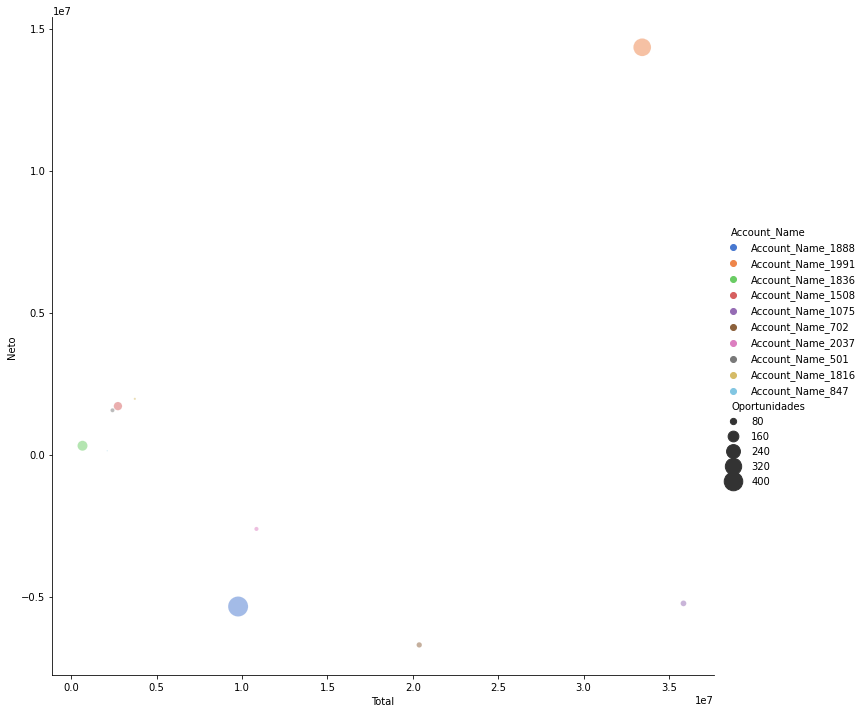

In [ ]:
groupping2_Japan = group2_aux_Japan.nlargest(10,"Oportunidades")

plot2_Japan = sns.relplot(x="Total", y="Neto", hue="Account_Name", size="Oportunidades",
                         sizes=(1, 400), alpha=.5, palette="muted",
                         height=10, data=groupping2_Japan)
 
#plot2_Japan.savefig('Analisis2_Japan',dpi=400)

#Analisis Global de Regiones


In [ ]:
datos_unicos_oportunidades = datos[['Opportunity_Name','Territory','Stage','Source','Account_Name'\
                                    ,'Opportunity_Created_Date','Opportunity_Owner','Region','Opportunity_Year','Semester']]\
                                    .drop_duplicates()

datos_unicos_oportunidades['semester_count'] = (((datos_unicos_oportunidades['Opportunity_Year']%2013)*2)+datos_unicos_oportunidades['Semester'])

datos_globales_oportunidades = datos.groupby('Opportunity_Name')\
                                    .agg({'Total_Amount_Converted':'sum','TRF':'sum','Opportunity_ID':'count'})\
                                    .rename(columns={'Total_Amount_Converted':'Total_Amount(Converted)','TRF':'Total_TRF','Opportunity_ID':'Items'})\
                                    .join(datos_unicos_oportunidades.set_index('Opportunity_Name'))

## Analisis 
Agrupamos oportunidades por region

In [ ]:
regiones = datos_globales_oportunidades.groupby(['Region','Opportunity_Year','semester_count','Stage'])\
                                       .agg({'Items':'count','Total_Amount(Converted)':'sum'})\
                                       .rename(columns={'Items':'Opportunities_per_Semester','Total_Amount(Converted)':'Total_Amount'})
                            
# Se calcula el promedio de monto por oportunidad para cada vendedor:
#regiones['Mean_Amount'] = regiones['Total_Amount']/regiones['Opportunities_per_Semester']
regiones = regiones.drop(columns='Opportunities_per_Semester')

regiones = regiones.reset_index().set_index(['Opportunity_Year','Stage'])
regiones

Region  semester_count  Total_Amount
Opportunity_Year Stage                                                 
2014             Closed Lost         APAC               3  1.080872e+07
                 Closed Lost         APAC               4  4.115900e+05
                 Closed Won          APAC               4  5.005000e+04
2015             Closed Lost         APAC               5  2.283880e+07
                 Closed Won          APAC               5  1.773383e+06
...                                   ...             ...           ...
2017             Closed Won   Middle East              10  3.986700e+05
2018             Closed Lost  Middle East              11  8.830913e+06
                 Closed Won   Middle East              11  1.207394e+06
                 Closed Lost  Middle East              12  2.045295e+06
                 Closed Won   Middle East              12  4.083443e+05

[84 rows x 3 columns]

#### Graficos

Text(0.5, 0, 'Semester')

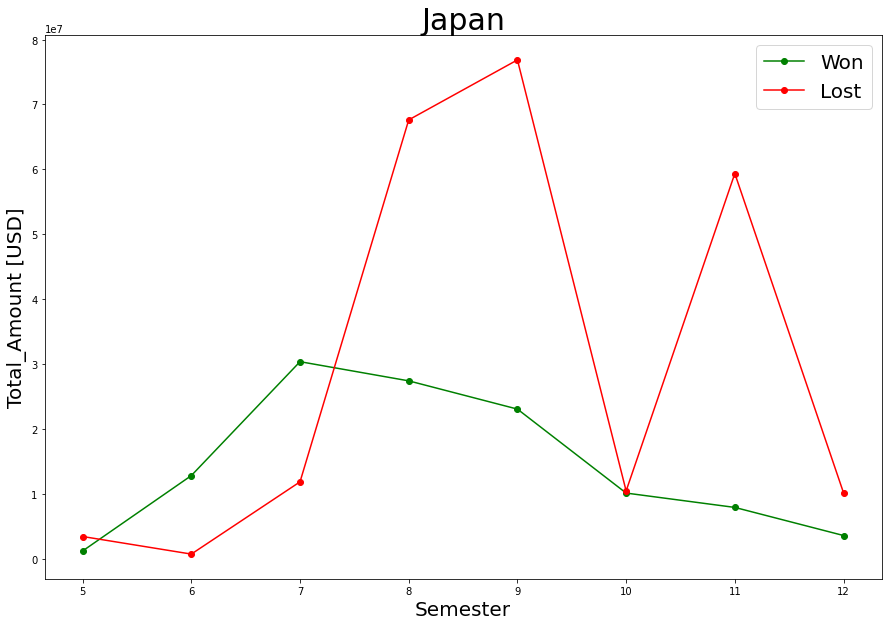

In [ ]:
# Grafico de una sola region:

datos_region = regiones[regiones.Region == 'Japan']

datos_region = datos_region.reset_index()
datos_won = datos_region[datos_region.Stage == 'Closed Won']
datos_lost = datos_region[datos_region.Stage == 'Closed Lost']

fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(111)
ax1.plot( datos_won['semester_count'],datos_won['Total_Amount'],color = 'green',marker='o')
ax1.plot( datos_lost['semester_count'],datos_lost['Total_Amount'],color = 'red',marker='o')
plt.title('Japan',fontsize=30)

ax1.legend(['Won','Lost'],loc='best',fontsize=20)
ax1.set_ylabel('Total_Amount [USD]', fontsize=20)
ax1.set_xlabel('Semester', fontsize=20)

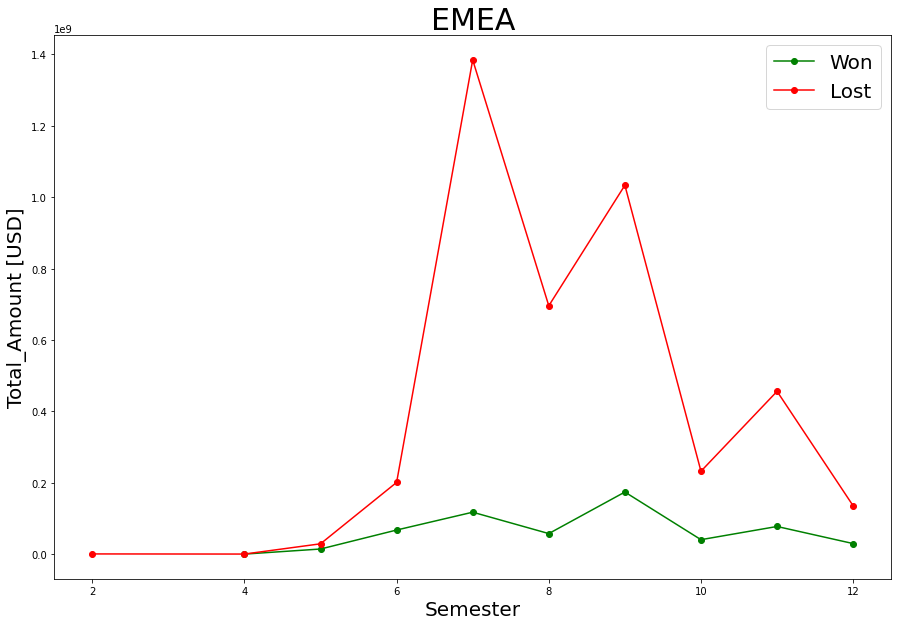

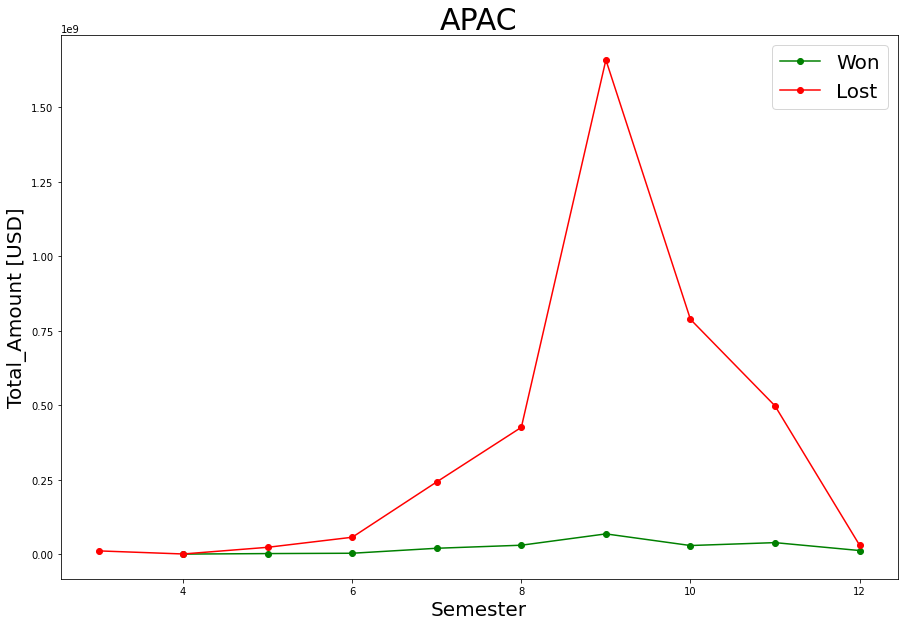

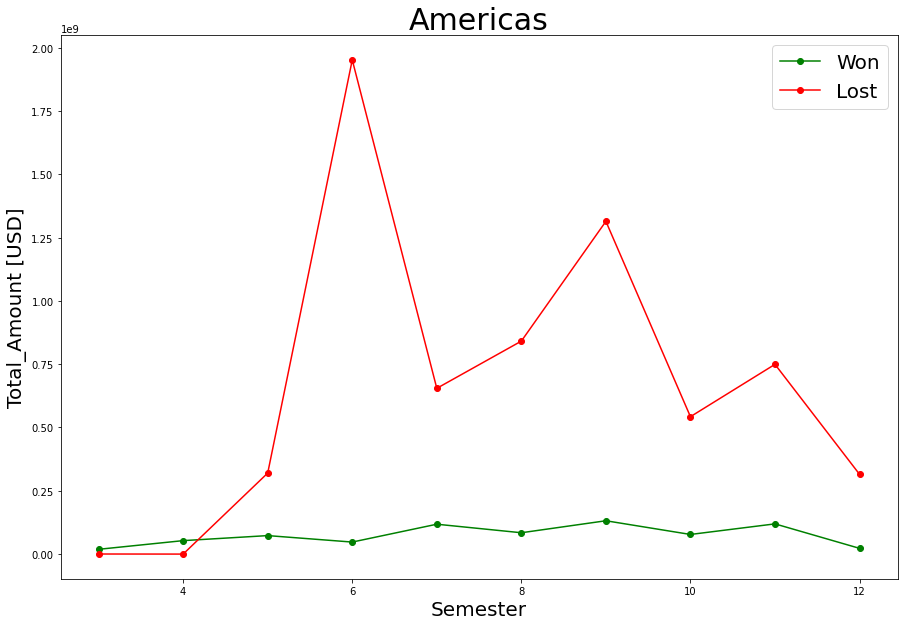

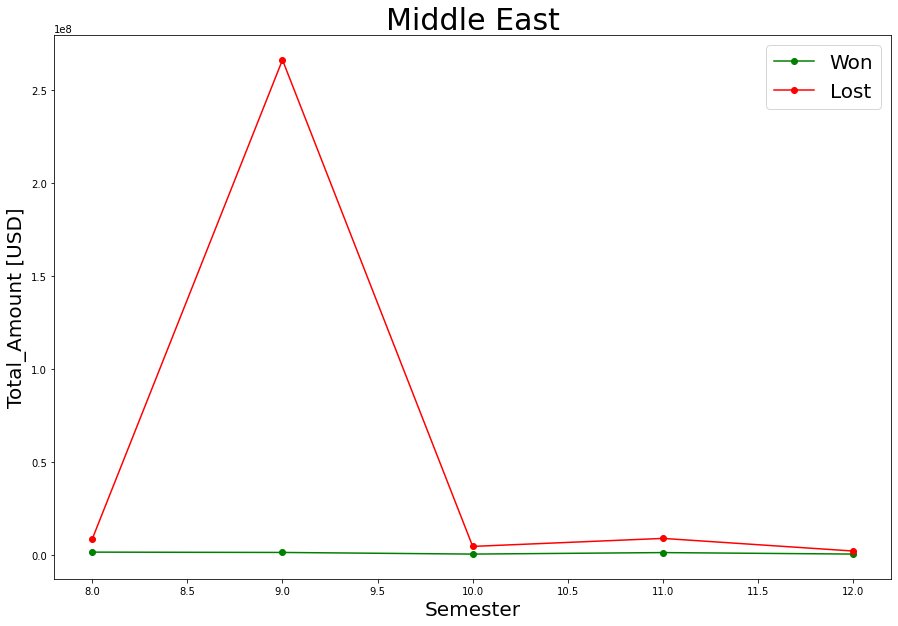

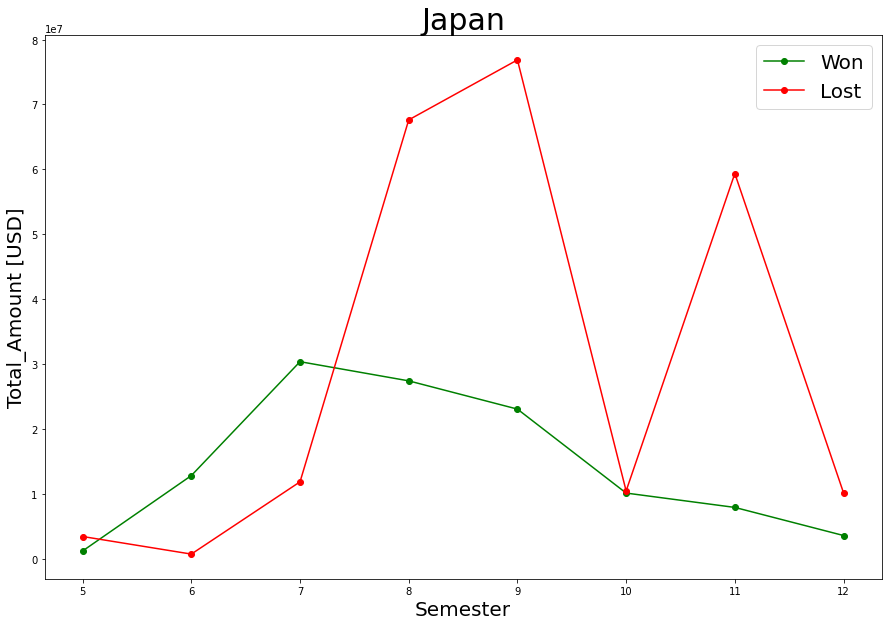

In [ ]:
# Graficos para todas las regiones:

regions = ['EMEA','APAC','Americas','Middle East','Japan']

for i,region in enumerate(regions):
  datos_region = regiones[regiones.Region == region]
  datos_region = datos_region.reset_index()
  datos_won = datos_region[datos_region.Stage == 'Closed Won']
  datos_lost = datos_region[datos_region.Stage == 'Closed Lost']

  fig = plt.figure(figsize=(15,10))
  ax1 = plt.subplot(111)
  ax1.plot( datos_won['semester_count'],datos_won['Total_Amount'],color = 'green',marker='o')
  ax1.plot( datos_lost['semester_count'],datos_lost['Total_Amount'],color = 'red',marker='o')
  plt.title(regions[i],fontsize=30)

  ax1.legend(['Won','Lost'],loc='best',fontsize=20)
  ax1.set_ylabel('Total_Amount [USD]', fontsize=20)
  ax1.set_xlabel('Semester', fontsize=20)

  #plt.savefig('Analisis4_{}'.format(regions[i]),bbox_inches='tight')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

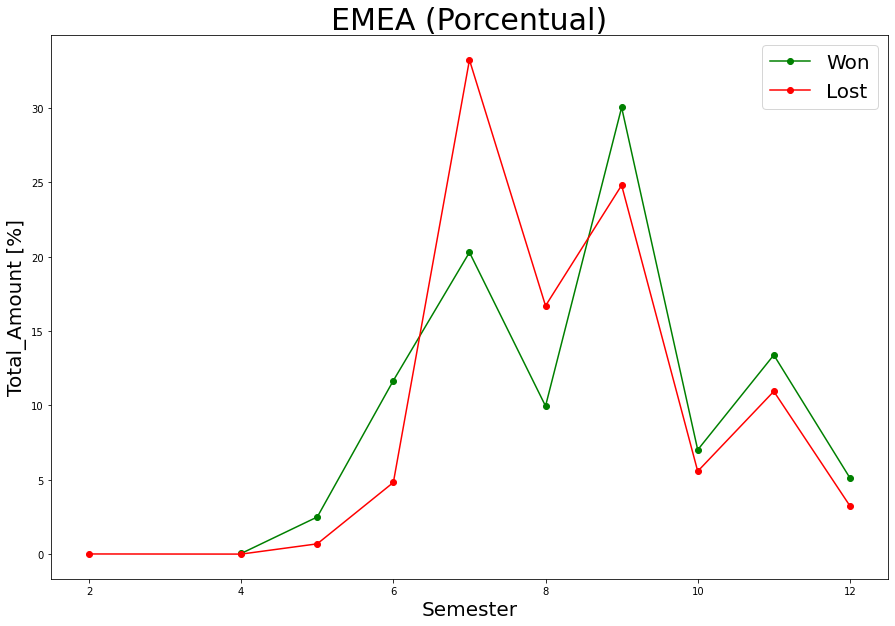

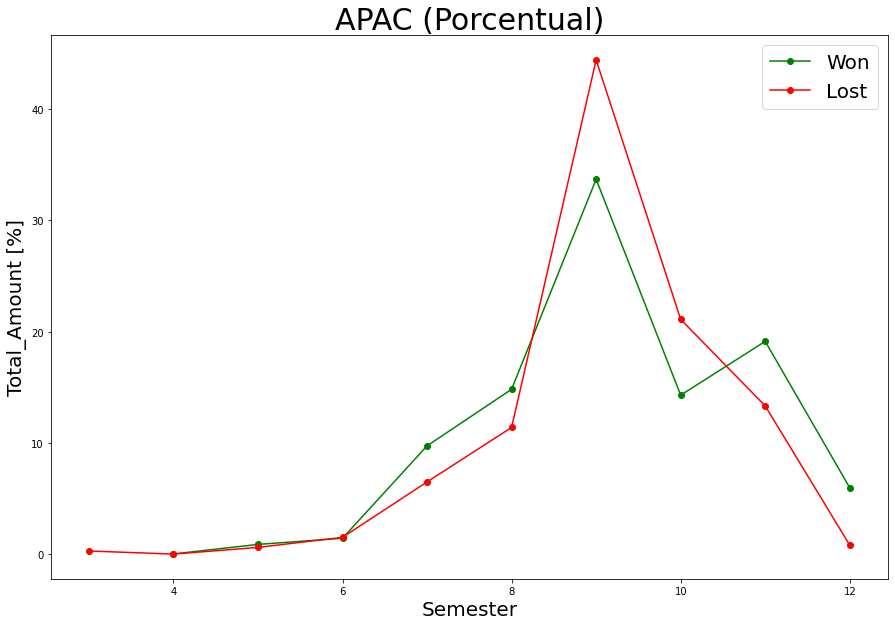

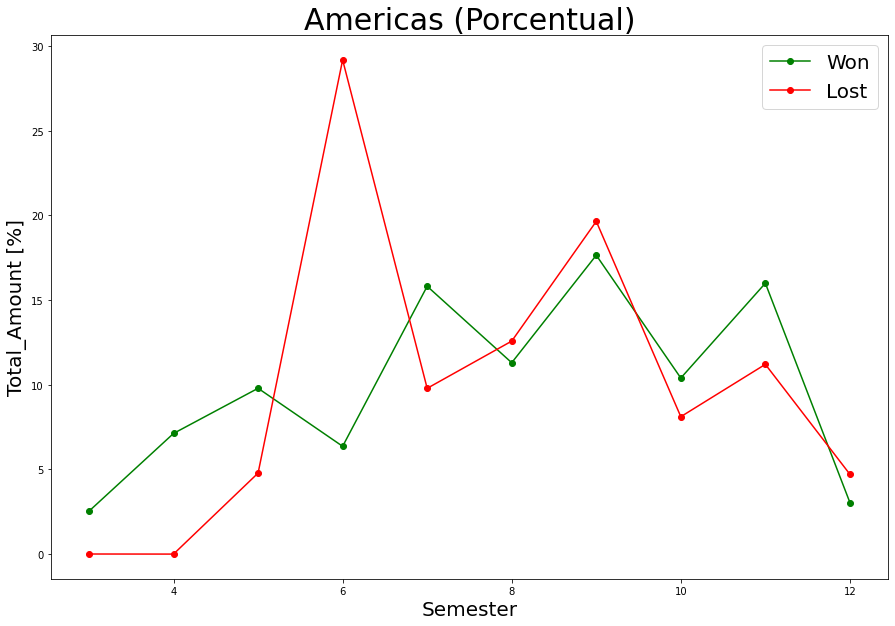

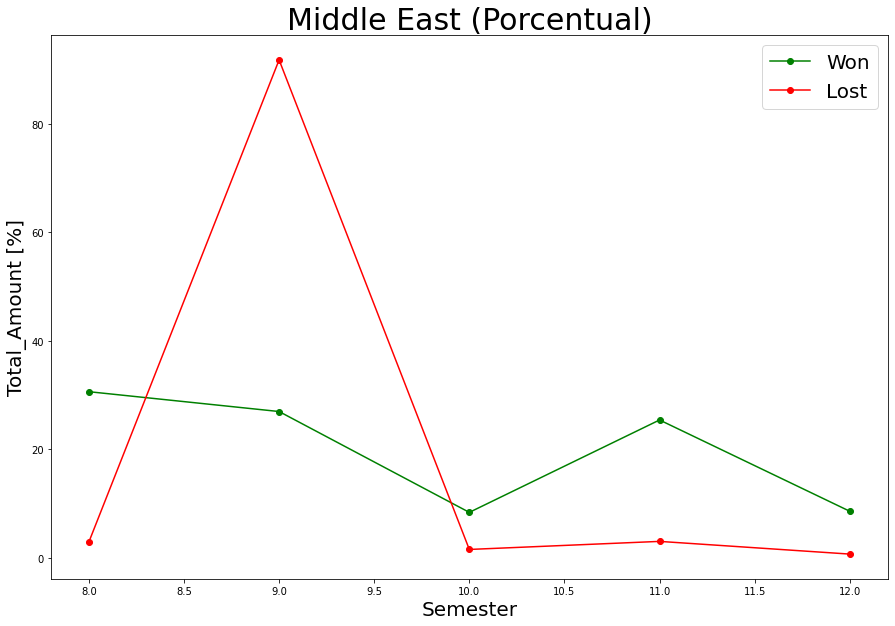

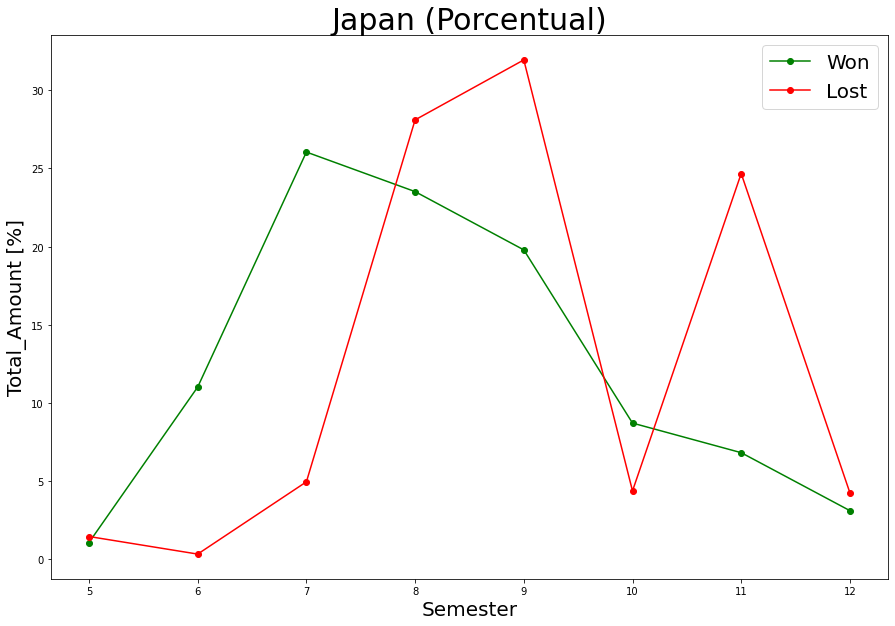

In [223]:
# idem que antes pero porcentual:

regions = ['EMEA','APAC','Americas','Middle East','Japan']

for i,region in enumerate(regions):
  datos_region = regiones[regiones.Region == region]
  datos_region = datos_region.reset_index()
  datos_won = datos_region[datos_region.Stage == 'Closed Won']
  datos_won['Total_Amount(%)'] = datos_won['Total_Amount']/datos_won['Total_Amount'].sum()*100
  datos_lost = datos_region[datos_region.Stage == 'Closed Lost']
  datos_lost['Total_Amount(%)'] = datos_lost['Total_Amount']/datos_lost['Total_Amount'].sum()*100

  fig = plt.figure(figsize=(15,10))
  ax1 = plt.subplot(111)
  ax1.plot( datos_won['semester_count'],datos_won['Total_Amount(%)'],color = 'green',marker='o')
  ax1.plot( datos_lost['semester_count'],datos_lost['Total_Amount(%)'],color = 'red',marker='o')
  plt.title(regions[i]+' (Porcentual)',fontsize=30)

  ax1.legend(['Won','Lost'],loc='best',fontsize=20)
  ax1.set_ylabel('Total_Amount [%]', fontsize=20)
  ax1.set_xlabel('Semester', fontsize=20)

  #plt.savefig('Analisis4_{}_porcentual'.format(regions[i]),bbox_inches='tight')